In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
import statsmodels.api as sm

In [6]:

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

In [7]:
print(X.head())
print("Target classes:", iris.target_names)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
Target classes: ['setosa' 'versicolor' 'virginica']


# Baseline Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

baseline_acc = lr.score(X_test, y_test)
print("Baseline Accuracy:", baseline_acc)

Baseline Accuracy: 1.0


# RFE

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_counts = []
cv_scores = []
for n in range(1, X.shape[1] + 1): 
    rfe = RFE(estimator=LogisticRegression(max_iter=200), n_features_to_select=n)
    X_rfe = rfe.fit_transform(X, y)
    score = cross_val_score(LogisticRegression(max_iter=200), X_rfe, y, cv=cv, scoring="accuracy").mean()
    feature_counts.append(n)
    cv_scores.append(score)
optimal_features = feature_counts[np.argmax(cv_scores)]
print("Optimal Number of Features:", optimal_features)
print("Best CV Accuracy:", max(cv_scores))

Optimal Number of Features: 2
Best CV Accuracy: 0.9666666666666668


In [10]:
# Baseline Model accuracy 1.0 while RFE has 0.9666666666666668 as it shows using RFE with Logistic Regression the optimal subset 
# of features is petal length and petal width. The baseline model with all 4 features achieved an accuracy of . After applying RFE, the model 
# using only 2 features achieved a similar accuracy (~96%).

# Decision Tree Classifier

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print("Baseline Accuracy including all Feature:", baseline_acc)

Baseline Accuracy including all Feature: 0.9333333333333333


In [12]:
importances = dt.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns,"Importance": importances}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Ranking:")
print(feature_importance_df)


Feature Importance Ranking:
             Feature  Importance
2  petal length (cm)    0.558568
3   petal width (cm)    0.406015
1   sepal width (cm)    0.029167
0  sepal length (cm)    0.006250


In [13]:
least_important = feature_importance_df.iloc[-1]["Feature"]
X_reduced = X.drop(columns=[least_important])
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split( X_reduced, y, test_size=0.3, random_state=42, stratify=y)

dt_reduced = DecisionTreeClassifier(random_state=42)
dt_reduced.fit(X_train_r, y_train_r)

y_pred_r = dt_reduced.predict(X_test_r)
reduced_acc = accuracy_score(y_test_r, y_pred_r)

print(f"\nAccuracy Without '{least_important}':", reduced_acc)


Accuracy Without 'sepal length (cm)': 0.9777777777777777


In [14]:
# Using a Decision Tree Classifier we computed feature importance scores for the Iris dataset
# The most important features were petal length and petal width, while sepal width contributed the least.
# The baseline model with all 4 features achieved an accuracy of 0.93333. After removing the least important feature (sepal width), 
# accuracy improved by 0.977777.

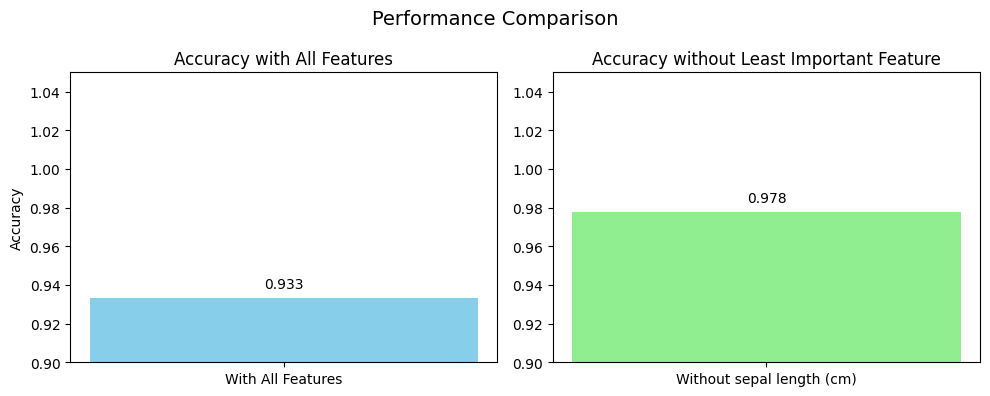

In [15]:
with_all = baseline_acc
without_feat = reduced_acc

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].bar(["With All Features"], [with_all], color="skyblue")
axes[0].set_title("Accuracy with All Features")
axes[0].set_ylim(0.9, 1.05)
axes[0].set_ylabel("Accuracy")
axes[0].text(0, with_all + 0.005, f"{with_all:.3f}", ha="center", fontsize=10)

axes[1].bar([f"Without {least_important}"], [without_feat], color="lightgreen")
axes[1].set_title("Accuracy without Least Important Feature")
axes[1].set_ylim(0.9, 1.05)
axes[1].text(0, without_feat + 0.005, f"{without_feat:.3f}", ha="center", fontsize=10)

plt.suptitle("Performance Comparison", fontsize=14)
plt.tight_layout()
plt.show()

# Mutual Information / Gini Index / Information Gain

In [16]:
mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores)

tree_gini = DecisionTreeClassifier(criterion="gini", random_state=42)
tree_gini.fit(X, y)
gini_scores = pd.Series(tree_gini.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Gini Index Scores:\n", gini_scores)

tree_entropy = DecisionTreeClassifier(criterion="entropy", random_state=42)
tree_entropy.fit(X, y)
ig_scores = pd.Series(tree_entropy.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Information Gain Scores:\n", ig_scores)

Mutual Information Scores:
 petal length (cm)    0.992573
petal width (cm)     0.985643
sepal length (cm)    0.511365
sepal width (cm)     0.299424
dtype: float64
Gini Index Scores:
 petal length (cm)    0.564056
petal width (cm)     0.422611
sepal length (cm)    0.013333
sepal width (cm)     0.000000
dtype: float64
Information Gain Scores:
 petal length (cm)    0.657034
petal width (cm)     0.331379
sepal length (cm)    0.011588
sepal width (cm)     0.000000
dtype: float64


In [17]:
comparison = pd.DataFrame({
    "Mutual Information": mi_scores,
    "Gini Index": gini_scores,
    "Information Gain": ig_scores
})

print("\nFeature Ranking Comparison:\n")
print(comparison)


Feature Ranking Comparison:

                   Mutual Information  Gini Index  Information Gain
petal length (cm)            0.992573    0.564056          0.657034
petal width (cm)             0.985643    0.422611          0.331379
sepal length (cm)            0.511365    0.013333          0.011588
sepal width (cm)             0.299424    0.000000          0.000000


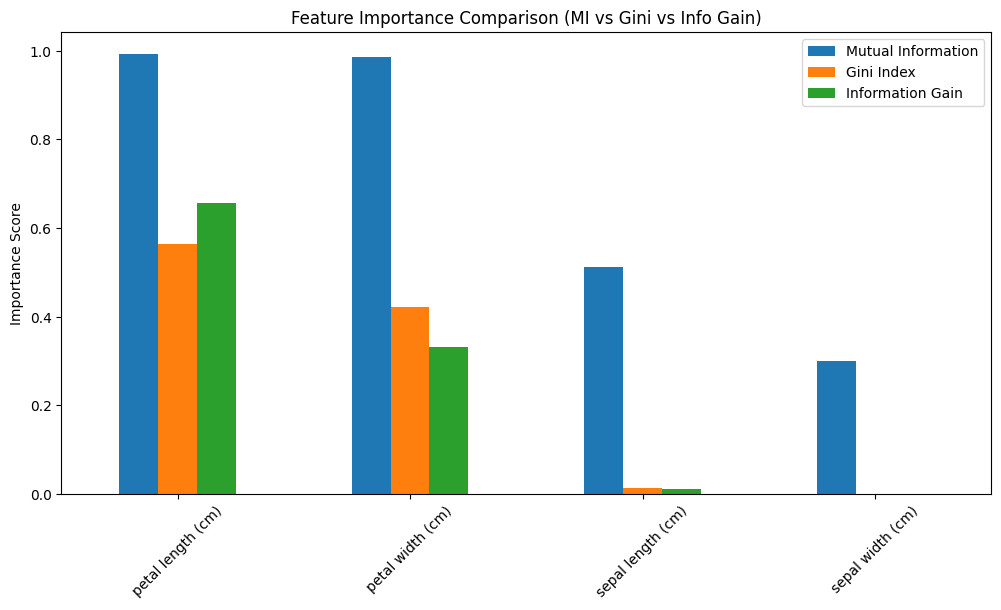

In [18]:
comparison.plot(kind="bar",figsize=(12,6))
plt.title("Feature Importance Comparison (MI vs Gini vs Info Gain)")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.show()

# Forward Selection

In [19]:
def forward_selection(X, y, model, cv=5):
    remaining_features = list(X.columns)
    selected_features = []
    performance = []

    while remaining_features:
        scores_with_candidates = []

        for feature in remaining_features:
            
            features_to_test = selected_features + [feature]
            score = cross_val_score(model, X[features_to_test], y, cv=cv).mean()
            scores_with_candidates.append((score, feature))

        scores_with_candidates.sort(reverse=True)
        best_score, best_feature = scores_with_candidates[0]

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        performance.append((list(selected_features), best_score))

    return performance
log_reg = LogisticRegression(max_iter=200)

results = forward_selection(X, y, log_reg)

for step, (features, score) in enumerate(results, start=1):
    print(f"Step {step}: Selected {features}, Accuracy = {score:.4f}")

Step 1: Selected ['petal width (cm)'], Accuracy = 0.9600
Step 2: Selected ['petal width (cm)', 'petal length (cm)'], Accuracy = 0.9600
Step 3: Selected ['petal width (cm)', 'petal length (cm)', 'sepal width (cm)'], Accuracy = 0.9667
Step 4: Selected ['petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)'], Accuracy = 0.9733


In [20]:
# featue with high importance like petal width and petal lenght add first and then the leastb important feature like sepal lenght and sepal width

# Backward Elimination

In [21]:
import statsmodels.api as sm

y_binary = (y == 0).astype(int)  

X_with_const = sm.add_constant(X)
model = sm.OLS(y_binary, X_with_const).fit()

def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while True:
        X_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_const).fit()
        p_values = model.pvalues.iloc[1:]  
        worst_pval = p_values.max()
        if worst_pval > significance_level:
            worst_feature = p_values.idxmax()
            print(f"Removing {worst_feature} (p-value={worst_pval:.4f})")
            features.remove(worst_feature)
        else:
            break
    return features

selected_features = backward_elimination(X, y_binary)
print("Final Selected Features:", selected_features)


Removing petal width (cm) (p-value=0.3608)
Final Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']


# L1 Regularization (Lasso Regression)

In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Before lasso regularization
before_lasso = Lasso(alpha=0.0, max_iter=10000)
before_lasso .fit(X_train, y_train)
y_pred_no_reg = before_lasso .predict(X_test)
score_no_reg = r2_score(y_test, y_pred_no_reg)

print("Coefficients before regularization:")
print(pd.Series(before_lasso .coef_, index=X.columns))
print("R2 Score before regularization:", score_no_reg)

lasso = Lasso(alpha=0.1, max_iter=10000)  
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
score_lasso = r2_score(y_test, y_pred)

print("\nCoefficients after L1 Regularization (Lasso):")
print(pd.Series(lasso.coef_, index=X.columns))
print("R2 Score after regularization:", score_lasso)

eliminated = X.columns[lasso.coef_ == 0]
print("\nEliminated Features:", list(eliminated))

Coefficients before regularization:
sepal length (cm)   -0.099555
sepal width (cm)    -0.044515
petal length (cm)    0.219499
petal width (cm)     0.622204
dtype: float64
R2 Score before regularization: 0.9139814715607814

Coefficients after L1 Regularization (Lasso):
sepal length (cm)    0.00000
sepal width (cm)    -0.00000
petal length (cm)    0.40866
petal width (cm)     0.00000
dtype: float64
R2 Score after regularization: 0.881478359744977

Eliminated Features: ['sepal length (cm)', 'sepal width (cm)', 'petal width (cm)']


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e+00, tolerance: 8.000e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.R

# Boruta Algorithm

In [56]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X_train.values, y_train)

boruta_features = X.columns[boruta.support_].tolist()
print("Boruta Selected Features:", boruta_features)

rf_boruta = RandomForestClassifier(n_estimators=100, random_state=42)
rf_boruta.fit(X_train[boruta_features], y_train)
y_pred_boruta = rf_boruta.predict(X_test[boruta_features])
print("Accuracy with Boruta Features:", accuracy_score(y_test, y_pred_boruta))

Boruta Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Accuracy with Boruta Features: 1.0


# Chi-Square Test (χ² Test)

In [52]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_scaled, y)

chi2_scores = pd.DataFrame({
    'Feature': iris.feature_names,
    'Chi2 Score': chi2_selector.scores_,
    'p-value': chi2_selector.pvalues_
})

print("Chi-Square Test Results:")
print(chi2_scores.sort_values(by="Chi2 Score", ascending=False))

selected_features = chi2_scores[chi2_scores["p-value"] < 0.05]["Feature"].tolist()
print("\nSignificant Features (p < 0.05):", selected_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)
print("\nAccuracy with All Features:", accuracy_score(y_test, y_pred_all))

rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train[selected_features], y_train)
y_pred_sel = rf_selected.predict(X_test[selected_features])
print("Accuracy with Chi-Square Selected Features:", accuracy_score(y_test, y_pred_sel))

Chi-Square Test Results:
             Feature  Chi2 Score       p-value
3   petal width (cm)   30.478068  2.408639e-07
2  petal length (cm)   26.861936  1.468942e-06
0  sepal length (cm)   11.377274  3.384203e-03
1   sepal width (cm)    4.470734  1.069529e-01

Significant Features (p < 0.05): ['sepal length (cm)', 'petal length (cm)', 'petal width (cm)']

Accuracy with All Features: 1.0
Accuracy with Chi-Square Selected Features: 1.0


# ANOVA F-Value

In [57]:
from sklearn.feature_selection import f_classif

f_values, p_values = f_classif(X, y)

anova_results = pd.DataFrame({
    "Feature": iris.feature_names,
    "F-Value": f_values,
    "p-Value": p_values
}).sort_values(by="F-Value", ascending=False)

print("ANOVA F-Test Results:")
print(anova_results)

significant_features = anova_results[anova_results["p-Value"] < 0.05]["Feature"].tolist()
print("\nSignificant Features (p < 0.05):", significant_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model with all features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)
print("\nAccuracy with All Features:", accuracy_score(y_test, y_pred_all))

# Model with significant features only
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X[significant_features], y, test_size=0.2, random_state=42)

rf_sig = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sig.fit(X_train_sig, y_train_sig)
y_pred_sig = rf_sig.predict(X_test_sig)
print("Accuracy with Significant Features:", accuracy_score(y_test_sig, y_pred_sig))

ANOVA F-Test Results:
             Feature      F-Value       p-Value
2  petal length (cm)  1180.161182  2.856777e-91
3   petal width (cm)   960.007147  4.169446e-85
0  sepal length (cm)   119.264502  1.669669e-31
1   sepal width (cm)    49.160040  4.492017e-17

Significant Features (p < 0.05): ['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']

Accuracy with All Features: 1.0
Accuracy with Significant Features: 1.0


# Correlation Matrix with Heatmap

Correlation Matrix:
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


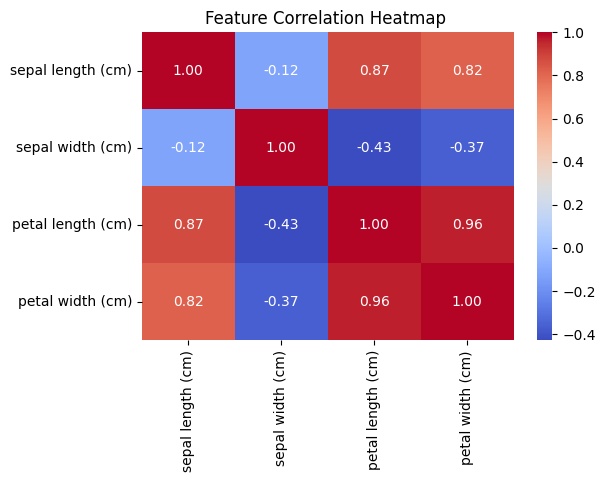


Accuracy with All Features: 1.0
Accuracy without Highly Correlated Features: 0.9666666666666667


In [61]:
import seaborn as sns

corr_matrix = X.corr()
print("Correlation Matrix:\n", corr_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap ")
plt.show()


# Model Performance Comparison
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model with all features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)
print("\nAccuracy with All Features:", accuracy_score(y_test, y_pred_all))

# Model without highly correlated features
X_reduced = X.drop(columns=high_corr_features)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_r, y_train_r)
y_pred_r = rf_reduced.predict(X_test_r)
print("Accuracy without Highly Correlated Features:", accuracy_score(y_test_r, y_pred_r))